In [1]:
#############################
## Load necessary packages ##
#############################

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.data import sciensano
from covid19model.models.utils import output_to_visuals
from covid19model.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc
from covid19model.visualization.output import _apply_tick_locator 

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## Define the settings

In [2]:
################################
## Define simulation settings ##
################################

# Number of simulations
N=100
# Number of neg. binomial draws/ simulation
K=1
# Number of age groups
age_stratification_size=10
# End of simulation
end_sim='2021-03-01'
# Confidence level used to visualise model fit
conf_int=0.05

##########################
## Define QALY settings ##
##########################

r=0.03

## Step 1: setup the national COVID-19 SEIQRD model

In [4]:
##################################################
## Load data not needed to initialize the model ##
##################################################

# Sciensano hospital and vaccination data
df_hosp, df_mort, df_cases, df_vacc = sciensano.get_sciensano_COVID19_data(update=False)
df_hosp = df_hosp.groupby(by=['date']).sum()
# Serological data
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()
# Deaths in hospitals
df_sciensano_mortality = sciensano.get_mortality_data()
deaths_hospital = df_sciensano_mortality.xs(key='all', level="age_class", drop_level=True)['hospital','cumsum']

##########################
## Initialize the model ##
##########################

model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size)

warmup = float(BASE_samples_dict['warmup'])
dispersion = float(BASE_samples_dict['dispersion'])
start_sim = BASE_samples_dict['start_calibration']

#######################
## Sampling function ##
#######################

from covid19model.models.utils import draw_fnc_COVID19_SEIQRD_hybrid_vacc as draw_fcn

## Step 2: Setup the QALY model

In [5]:
# Obtain the number of QALYs that would be lost if a person of a given age dies
from covid19model.models.QALY import QALY_model
life_table_QALY_model = QALY_model()

## Step 3: Simulate the epidemiological model

In [8]:
#########################
## Perform simulations ##
#########################

print('\n1) Simulating COVID19_SEIQRD_hybrid_vacc '+str(N)+' times')
N=10
out = model.sim(end_sim,start_date=start_sim, warmup=warmup, N=N, draw_fcn=draw_fcn, samples=BASE_samples_dict)


1) Simulating COVID19_SEIQRD_hybrid_vacc 90 times


## Step 4: Perform ex-ante QALY calculation

In [19]:
QALY_binned = life_table_QALY_model.bin_QALY_x(life_table_QALY_model.compute_QALY_x(r=r))

In [20]:
def append_QALY_D(out, QALY_binned):
    out['QALY_D'] = out['D']*QALY_binned[np.newaxis,:,np.newaxis,np.newaxis]
    return out

In [21]:
out = append_QALY_D(out, QALY_binned)

/tmp/ipykernel_121230/3658340651.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out['QALY_D'] = out['D']*QALY_binned[np.newaxis,:,np.newaxis,np.newaxis]


## Step 5: Visualize result

2) Visualizing fit


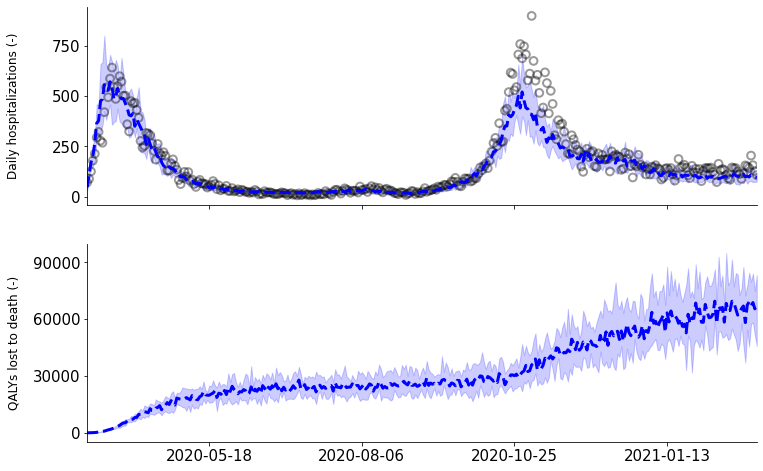

In [22]:
df_2plot = output_to_visuals(out, ['H_in', 'H_tot', 'S', 'R', 'D', 'QALY_D'], alpha=dispersion, n_draws_per_sample=K, UL=1-conf_int*0.5, LL=conf_int*0.5)
simtime = out['time'].values

#######################
## Visualize results ##
#######################

print('2) Visualizing fit')

# Plot hospitalizations
fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(12,8))
ax1.plot(df_2plot['H_in','mean'],'--', color='blue')
ax1.fill_between(simtime, df_2plot['H_in','lower'], df_2plot['H_in','upper'],alpha=0.20, color = 'blue')
ax1.scatter(df_hosp[start_sim:end_sim].index,df_hosp['H_in'][start_sim:end_sim], color='black', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)
ax1 = _apply_tick_locator(ax1)
ax1.set_xlim(start_sim,end_sim)
ax1.set_ylabel('Daily hospitalizations (-)', fontsize=12)
ax1.get_yaxis().set_label_coords(-0.1,0.5)
ax1.grid(False)

# Plot QALY loss due to death
ax2.plot(df_2plot['QALY_D','mean'],'--', color='blue')
ax2.fill_between(simtime, df_2plot['QALY_D','lower'], df_2plot['QALY_D','upper'],alpha=0.20, color = 'blue')
ax2 = _apply_tick_locator(ax2)
ax2.set_xlim(start_sim,end_sim)
ax2.set_ylabel('QALYs lost to death (-)', fontsize=12)
ax2.get_yaxis().set_label_coords(-0.1,0.5)
ax2.grid(False)

plt.show()
plt.close()